# Análisis del Comportamiento del Usuario y Test AAB en Aplicación de Ventas de Productos Alimenticios 

## Introducción 

En una empresa emergente dedicada a la venta de productos alimenticios,  mi responsabilidad es investigar el comportamiento del usuario para la aplicación. Para comenzar, se estudio el embudo de ventas y entendio cómo nuestros usuarios llegan a la etapa de compra. Me intereso saber cuántos realmente alcanzan esta fase, cuántos se quedan atascados en etapas anteriores y cuáles son esas etapas problemáticas.

Además, analice los resultados de un test A/A/B. El equipo de diseño propuso cambiar las fuentes de toda la aplicación, pero la gerencia estaba preocupada de que los usuarios perciban el nuevo diseño como intimidante. Por eso, decidimos basar nuestra decisión en los resultados de este test.

En el test, hemos dividido a los usuarios en tres grupos: dos grupos de control que mantienen las fuentes antiguas y un grupo de prueba que utiliza las nuevas. Mi objetivo es determinar qué conjunto de fuentes genera mejores resultados.







## Descripción de los datos 

Cada entrada de registro es una acción de usuario o un evento.

event_name: nombre del evento.

uid: identificador de usuario unívoco.

event_ts: hora del evento.

expid: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

# Descripción y procesamiento de datos 

In [97]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

In [5]:
log_exp_df  = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t' )

In [6]:
log_exp_df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Se realizó el acomodo del formato de la tabla, ahora se realizaran cambios en el nombre de las columnas y se agregara una columna de fecha. 

Además se comprobara si hay datos ausentes. 

In [7]:
log_exp_df = log_exp_df.rename(columns = {'EventName':'event_name', 'DeviceIDHash': 'uid', 'EventTimestamp': 'event_ts', 'ExpId': 'expid'})

In [8]:
log_exp_df

,event_name,uid,event_ts,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [9]:
log_exp_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   uid         244126 non-null  int64 
 2   event_ts    244126 non-null  int64 
 3   expid       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [10]:
log_exp_df['event_ts'] = pd.to_datetime(log_exp_df['event_ts'], unit='s')

In [11]:
log_exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   uid         244126 non-null  int64         
 2   event_ts    244126 non-null  datetime64[ns]
 3   expid       244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [12]:
log_exp_df['date'] = log_exp_df ['event_ts'].dt.date 
log_exp_df['time'] = log_exp_df ['event_ts'].dt.time 

In [13]:
log_exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   uid         244126 non-null  int64         
 2   event_ts    244126 non-null  datetime64[ns]
 3   expid       244126 non-null  int64         
 4   date        244126 non-null  object        
 5   time        244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


In [14]:
log_exp_df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

## Estudiar y comprobar los datos 

¿Cuántos eventos hay en los registros?

¿Cuántos usuarios y usuarias hay en los registros?

¿Cuál es el promedio de eventos por usuario?

¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

### ¿Cuántos eventos hay en los registros?

In [15]:
log_exp_df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [16]:
total_event = log_exp_df.shape[0]
print(total_event)

244126


En general hay 5 eventos en los registros, los cuales son;
1. MainScreenappear = Aparece pantalla principal. 
2. PaymentScreenSuccesful = Pantalla de pago exitosa
3. CartScreenAppear = Aparecera pantalla de carrito
4. OfferScreenApear = Aparece pantalla de ofertas
5. Tutorial = Tutorial 

En los registros hay un total de 244126 eventos. 

### ¿Cuántos usuarios y usuarias hay en los registros?

In [17]:
print('Total de usuarios en los registros:')
total_users = log_exp_df['uid'].nunique() 
print(total_users)

Total de usuarios en los registros:
7551


### ¿Cuál es el promedio de eventos por usuario?

In [18]:
events_per_user = total_event/total_users 
print(f'Promedio de eventos por usario: {events_per_user}')

Promedio de eventos por usario: 32.33028737915508


### ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?


In [19]:
print('fecha mínima:', log_exp_df['event_ts'].min()) 
print('fecha máxima:', log_exp_df['event_ts'].max()) 

fecha mínima: 2019-07-25 04:43:36
fecha máxima: 2019-08-07 21:15:17


In [25]:
events_per_date = log_exp_df['date'].value_counts().sort_index()

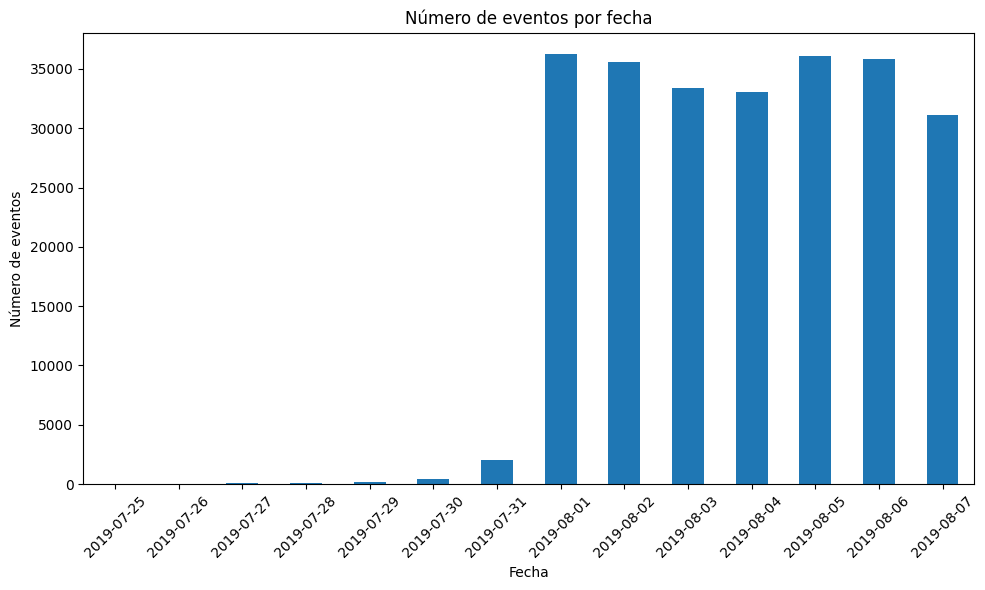

In [26]:

plt.figure(figsize=(10, 6))
events_per_date.plot(kind='bar')
plt.title('Número de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
events_per_date.describe()

count       14.000000
mean     17437.571429
std      17734.124149
min          9.000000
25%        124.750000
50%      16587.500000
75%      35042.250000
max      36229.000000
Name: date, dtype: float64

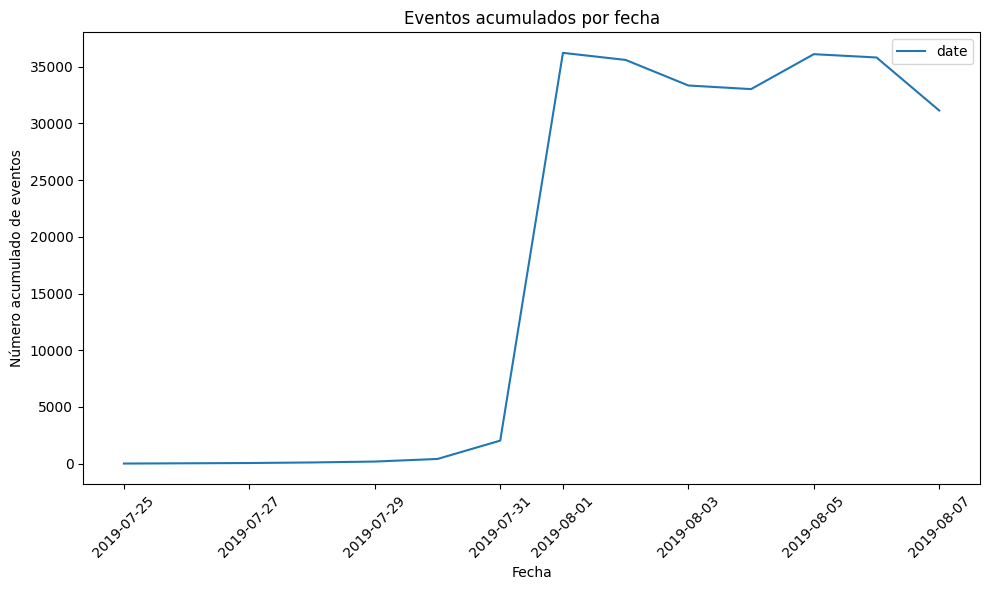

In [31]:
plt.figure(figsize=(10, 6))
events_per_date.plot()
plt.title('Eventos acumulados por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número acumulado de eventos')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Parece que los datos se estabilizan a partir de 31 de julio, tomaremos el periodo de 31-07-2019 al 07-08-2019

In [34]:
log_exp_df['date'] = pd.to_datetime(log_exp_df['date'])

# Se filtra el DataFrame para incluir solo las fechas después del 31 de julio de 2019
log_exp_df = log_exp_df[log_exp_df['date'] > pd.Timestamp('2019-07-31')]

### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [35]:
log_exp_df

,event_name,uid,event_ts,expid,date,time
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


In [85]:
total_users = log_exp_df['uid'].nunique()
total_users

7534

En cuanto a número de eventos se perdieron 2,828, mientras que unicamente se perdieron 17 usuarios.

### Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [44]:
g246 = log_exp_df[log_exp_df['expid']== 246]
g246

,event_name,uid,event_ts,expid,date,time
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2834,OffersScreenAppear,3737462046622621720,2019-08-01 00:10:26,246,2019-08-01,00:10:26
...,...,...,...,...,...,...
244120,MainScreenAppear,5746969938801999050,2019-08-07 21:12:11,246,2019-08-07,21:12:11
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


In [45]:
g247 = log_exp_df[log_exp_df['expid']== 247]
g247

,event_name,uid,event_ts,expid,date,time
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59
2833,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01,00:10:15
2838,MainScreenAppear,4899590676214355127,2019-08-01 00:11:28,247,2019-08-01,00:11:28
2839,OffersScreenAppear,4899590676214355127,2019-08-01 00:11:30,247,2019-08-01,00:11:30
2843,OffersScreenAppear,4899590676214355127,2019-08-01 00:12:36,247,2019-08-01,00:12:36
...,...,...,...,...,...,...
244088,MainScreenAppear,2300292234025330845,2019-08-07 21:05:37,247,2019-08-07,21:05:37
244089,OffersScreenAppear,2300292234025330845,2019-08-07 21:05:43,247,2019-08-07,21:05:43
244090,OffersScreenAppear,2300292234025330845,2019-08-07 21:05:54,247,2019-08-07,21:05:54
244091,MainScreenAppear,2300292234025330845,2019-08-07 21:05:57,247,2019-08-07,21:05:57


In [47]:
g248 = log_exp_df[log_exp_df['expid']== 248]
g248

,event_name,uid,event_ts,expid,date,time
2844,MainScreenAppear,4613461174774205834,2019-08-01 00:14:31,248,2019-08-01,00:14:31
2845,MainScreenAppear,4613461174774205834,2019-08-01 00:14:34,248,2019-08-01,00:14:34
2846,CartScreenAppear,4613461174774205834,2019-08-01 00:14:34,248,2019-08-01,00:14:34
2847,PaymentScreenSuccessful,4613461174774205834,2019-08-01 00:14:43,248,2019-08-01,00:14:43
2848,OffersScreenAppear,4613461174774205834,2019-08-01 00:14:51,248,2019-08-01,00:14:51
...,...,...,...,...,...,...
244082,MainScreenAppear,8249271441488197538,2019-08-07 21:03:33,248,2019-08-07,21:03:33
244084,OffersScreenAppear,8249271441488197538,2019-08-07 21:03:43,248,2019-08-07,21:03:43
244109,MainScreenAppear,5317814261427487562,2019-08-07 21:09:22,248,2019-08-07,21:09:22
244110,OffersScreenAppear,5317814261427487562,2019-08-07 21:09:27,248,2019-08-07,21:09:27


## Estudiar el embudo de eventos

### Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [49]:
log_exp_df['event_name'].unique() 

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [51]:
event_freq = log_exp_df['event_name'].value_counts() 

In [52]:
event_freq = event_freq.sort_values(ascending=False)

In [53]:
event_freq

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event_name, dtype: int64

### Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [54]:
users_per_event = log_exp_df.groupby('event_name')['uid'].nunique()

In [65]:
users_per_event = users_per_event.sort_values(ascending=False).sort_index()

In [66]:
users_per_event 

event_name
CartScreenAppear           3734
MainScreenAppear           7419
OffersScreenAppear         4593
PaymentScreenSuccessful    3539
Tutorial                    840
Name: uid, dtype: int64

In [58]:
user_percent = users_per_event/total_users

In [59]:
user_percent

event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: uid, dtype: float64

Al 90% de los usuarios les Aparece pantalla principal 

Al 46% de usuarios tienen una Pantalla de pago exitosa

Al 49% de usuarios les Aparece pantalla de carrito

Al 60% de los usuarios les Aparece pantalla de ofertas

El Tutorial unicamente el 11% de los usuarios realizaron este evento. 

### ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

La secuencia lógica es la siguiente:

    -Tutorial
    -MainScreenAppear
    -OffersScreenAppear
    -CartScreenAppear
    -PaymentScreenSuccessful 
    
No todas son necesarias para un embudo, por ejemplo, tutorial puede descartarse al hacer un embudo en exito de compras, ya que un usuario puede saltarse este pase y realizar su compra sin ningún inconveniente

### Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [68]:
events = users_per_event.index.tolist()
counts = users_per_event.values

proportion = pd.DataFrame ({'Events':events,
                           'uid_uniques':counts,
                           'transitio_ratio':[None] * len(counts)})

In [70]:
for i in range(len(counts) - 1):
    proportion.loc[i + 1, 'transitio_ratio'] = counts[i + 1] / counts[i] if counts[i] > 0 else 0

In [73]:
print(proportion)

                    Events  uid_uniques transitio_ratio
0         CartScreenAppear         3734            None
1         MainScreenAppear         7419        1.986877
2       OffersScreenAppear         4593        0.619086
3  PaymentScreenSuccessful         3539         0.77052
4                 Tutorial          840        0.237355


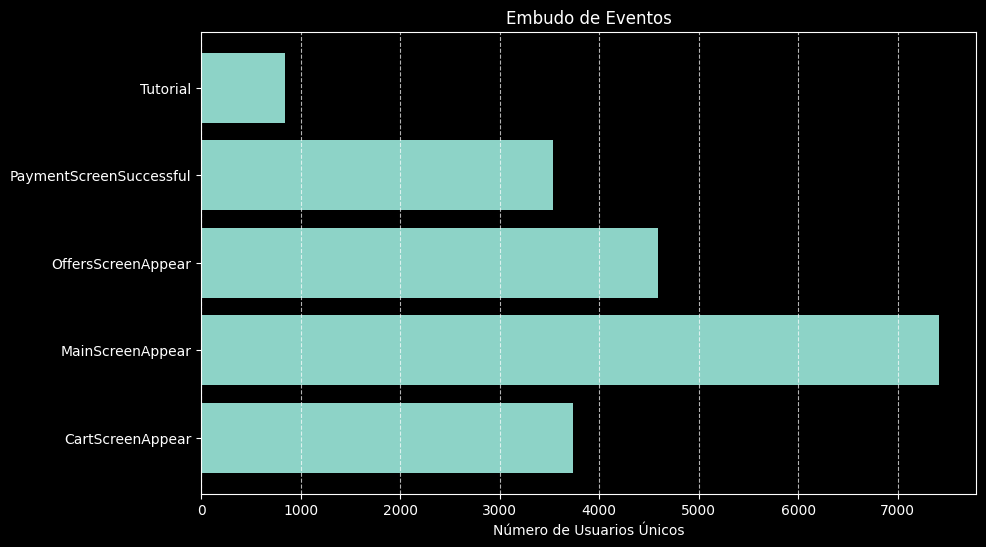

In [80]:
plt.figure(figsize=(10, 6))
plt.barh(proportion['Events'], proportion['uid_uniques'])
plt.xlabel('Número de Usuarios Únicos')
plt.title('Embudo de Eventos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

### ¿En qué etapa pierdes más usuarios y usuarias?

Sin considerar la etapa de tutorial y la pagina de ofertas, ya que no es un evento que sea indispensable para que un usuario realice una compra, el evento donde más se pierden usuarios es en "PaymentScreenSuccessful"

### ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [83]:
users_payment = log_exp_df[log_exp_df['event_name'] == 'PaymentScreenSuccessful']['uid'].nunique()

In [86]:
first_event = log_exp_df[log_exp_df['event_name'] == 'MainScreenAppear']['uid'].nunique()

In [87]:
if first_event > 0:
    porcent = (users_payment/ first_event) * 100
else:
    porcent= 0

print(f"El porcentaje de usuarios que hace todo el viaje desde el primer evento hasta el pago es: {porcent:.2f}%")

El porcentaje de usuarios que hace todo el viaje desde el primer evento hasta el pago es: 47.70%


## Estudiar los resultados del experimento

### ¿Cuántos usuarios y usuarias hay en cada grupo?

In [94]:
total_g246 = g246['uid'].nunique()
total_g247 = g247['uid'].nunique()
total_g248 = g248['uid'].nunique()

In [95]:
print(f'Hay {total_g246} usuarios en el grupo 246')
print(f'Hay {total_g247} usuarios en el grupo 247')
print(f'Hay {total_g248} usuarios en el grupo 248')

Hay 2484 usuarios en el grupo 246
Hay 2513 usuarios en el grupo 247
Hay 2537 usuarios en el grupo 248


### Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

Hipótesis nula (H0): No hay diferencia entre los grupos 246 y 247.

Hipótesis alternativa (H1): Hay una diferencia entre los grupos 246 y 247

In [108]:
event_g246 = g246.groupby('event_name')['uid'].nunique()

In [113]:
event_g246

event_name
CartScreenAppear           1266
MainScreenAppear           2450
OffersScreenAppear         1542
PaymentScreenSuccessful    1200
Tutorial                    278
Name: uid, dtype: int64

In [109]:
event_g247 = g247.groupby('event_name')['uid'].nunique()



In [110]:
event_g247 

event_name
CartScreenAppear           1238
MainScreenAppear           2476
OffersScreenAppear         1520
PaymentScreenSuccessful    1158
Tutorial                    283
Name: uid, dtype: int64

In [112]:
t_stat, p_value = stats.ttest_ind(event_g246, event_g247 )

print(f'Estadístico t: {t_stat}')
print(f'Valor p: {p_value}')


alpha = 0.05
if p_value < alpha:
    print('Hay una diferencia estadísticamente significativa entre los grupos 246 y 247.')
else:
    print('No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.')

Estadístico t: 0.02462483464245995
Valor p: 0.9809573661651472
No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.


### Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [137]:
evento_mas_popular = 'MainScreenAppear'
users_246 = g246[g246['event_name'] == 'MainScreenAppear']['uid'].nunique()
users_247 = g247[g247['event_name'] == 'MainScreenAppear']['uid'].nunique()


In [132]:
proportion246 = users_246 / total_g246
proportion247 = users_247 / total_g247

In [139]:
tabla_contingencia = [[users_246, total_g246 - users_246],
                      [users_247, total_g247 - users_247]]

chi2, p_value, _, _ = stats.chi2_contingency(tabla_contingencia)

print(f'Evento: {evento_mas_popular}')
print(f'Usuarios en 246: {users_246}, Proporción: {proportion246:.2f}')
print(f'Usuarios en 247: {users_247}, Proporción: {proportion247:.2f}')
print(f'Chi2: {chi2}, p-valor: {p_value}')

Evento: MainScreenAppear
Usuarios en 246: 2450, Proporción: 0.99
Usuarios en 247: 2476, Proporción: 0.99
Chi2: 0.03602851682130365, p-valor: 0.8494566142966455


Hipótesis nula (H0): No hay diferencia entre los grupos 246 y 247.

Hipótesis alternativa (H1): Hay una diferencia entre los grupos 246 y 247

In [143]:
eventos_frecuencia = log_exp_df['event_name'].value_counts()
def analizar_evento(log_exp_df, evento):
    grupo_246 = log_exp_df[log_exp_df['expid'] == 246]
    grupo_247 = log_exp_df[log_exp_df['expid'] == 247]

    usuarios_246 = grupo_246[grupo_246['event_name'] == evento]['uid'].nunique()
    usuarios_247 = grupo_247[grupo_247['event_name'] == evento]['uid'].nunique()

    total_usuarios_246 = grupo_246['uid'].nunique()
    total_usuarios_247 = grupo_247['uid'].nunique()

    proporcion_246 = usuarios_246 / total_usuarios_246
    proporcion_247 = usuarios_247 / total_usuarios_247

  
    tabla_contingencia = [[usuarios_246, total_usuarios_246 - usuarios_246],
                          [usuarios_247, total_usuarios_247 - usuarios_247]]

    chi2, p_value, _, _ = stats.chi2_contingency(tabla_contingencia)

    return {
        'evento': evento,
        'usuarios_246': usuarios_246,
        'proporcion_246': proporcion_246,
        'usuarios_247': usuarios_247,
        'proporcion_247': proporcion_247,
        'chi2': chi2,
        'p_value': p_value
    }

# Aplicar la función a todos los eventos
resultados = []
for evento in eventos_frecuencia.index:
    resultados.append(analizar_evento(log_exp_df, evento))

# Convertir resultados a un DataFrame
resultados_df = pd.DataFrame(resultados)
print(resultados_df)

                    evento  usuarios_246  proporcion_246  usuarios_247  \
0         MainScreenAppear          2450        0.986312          2476   
1       OffersScreenAppear          1542        0.620773          1520   
2         CartScreenAppear          1266        0.509662          1238   
3  PaymentScreenSuccessful          1200        0.483092          1158   
4                 Tutorial           278        0.111916           283   

   proporcion_247      chi2   p_value  
0        0.985277  0.036029  0.849457  
1        0.604855  1.267755  0.260188  
2        0.492638  1.380802  0.239965  
3        0.460804  2.401436  0.121224  
4        0.112614  0.001112  0.973395  


Si el p-valor es menor que 𝛼
α, se rechaza la hipótesis nula. Esto indica que hay evidencia suficiente para concluir que hay una diferencia significativa entre las categorías.

Un valor más alto de chi-cuadrado indica una mayor diferencia entre las frecuencias observadas y esperadas.

Dado que ningun numero es menor que 0.05 en p_value indica que no hay ninguna diferencia significativa.  


### Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [144]:
eventos_frecuencia = log_exp_df['event_name'].value_counts()
# Función para analizar un evento en los grupos
def analizar_evento_comparativo(log_exp_df, evento):
    # Contar usuarios únicos para cada grupo
    users_246 = g246[g246['event_name'] == evento]['uid'].nunique()
    users_247 = g247[g247['event_name'] == evento]['uid'].nunique()
    users_248 = g248[g248['event_name'] == evento]['uid'].nunique()
    
    total_246 = g246['uid'].nunique()
    total_247 = g247['uid'].nunique()
    total_248 = g248['uid'].nunique()
    
   
    proportion_246 = users_246 / total_246
    proportion_247 = users_247 / total_247
    proportion_248 = users_248 / total_248
    
    #  tabla de contingencia para chi-cuadrado
    tabla_contingencia_246_248 = [[users_246, total_246 - users_246],
                                   [users_248, total_248 - users_248]]
    
    tabla_contingencia_247_248 = [[users_247, total_247 - users_247],
                                   [users_248, total_248 - users_248]]
    
    
    chi2_246_248, p_value_246_248, _, _ = stats.chi2_contingency(tabla_contingencia_246_248)
    chi2_247_248, p_value_247_248, _, _ = stats.chi2_contingency(tabla_contingencia_247_248)
    
    return {
        'evento': evento,
        'usuarios_246': users_246,
        'proporcion_246': proportion_246,
        'usuarios_247': users_247,
        'proporcion_247': proportion_247,
        'usuarios_248': users_248,
        'proporcion_248': proportion_248,
        'chi2_246_248': chi2_246_248,
        'p_value_246_248': p_value_246_248,
        'chi2_247_248': chi2_247_248,
        'p_value_247_248': p_value_247_248,
    }

# Analizar todos los eventos
resultados = []
for evento in log_exp_df['event_name'].unique():
    resultados.append(analizar_evento_comparativo(log_exp_df, evento))

# Convertir resultados a un DataFrame
resultados_df = pd.DataFrame(resultados)
print(resultados_df)


                    evento  usuarios_246  proporcion_246  usuarios_247  \
0                 Tutorial           278        0.111916           283   
1         MainScreenAppear          2450        0.986312          2476   
2       OffersScreenAppear          1542        0.620773          1520   
3         CartScreenAppear          1266        0.509662          1238   
4  PaymentScreenSuccessful          1200        0.483092          1158   

   proporcion_247  usuarios_248  proporcion_248  chi2_246_248  \
0        0.112614           279        0.109972      0.030396   
1        0.985277          2493        0.982657      0.870773   
2        0.604855          1531        0.603469      1.510734   
3        0.492638          1230        0.484825      2.998600   
4        0.460804          1181        0.465510      1.486262   

   p_value_246_248  chi2_247_248  p_value_247_248  
0         0.861595      0.064389         0.799688  
1         0.350741      0.395598         0.529371  
2       


Debido a que se encontro que en los p-valores son mayores a 0.05 en las comparaciones entre el grupo 248 y los grupos control, indicó que no hay una diferencia significativa entre los gruposs. 

Al comparar las proporciones enel grupo 248, y que no se comportaron de una manera diferente relación a los grupos de control,  podría sugerir que el nuevo diseño no afecta el comportamiento de los usuarios.

### ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

Para probar las hipotesis se utilizo unb nivel de significancia del 0.05, lo que implica que existe un 5% de probabilidad de obtener un resultado falso positivo. el nivel de significación es 0.1 (10%).

Cuando se realizan varias pruebas de hipótesis, el riesgo de cometer un error tipo I (falso positivo) aumenta. Esto es conocido como el problema de las comparaciones múltiples. Si se usa un nivel de significación de 0.1 para cada prueba, la probabilidad de obtener al menos un resultado falso positivo en varias pruebas aumenta.

Si se utiliza un nivel de significación de 0.1 sin ninguna corrección, aproximadamente 1 de cada 10 resultados podría ser falso.Por lo que se dejara el nivel de significación en 0.05.